---
---
---
# CONVOLUTION NEURAL NETWORKS (CNN)
---
---
---

---
---
# CNN İLE KATI ATIK TESPİTİ
---
---

---
1-) Business Problem (İş Problemi)

2-) Data Understanding (Veriyi Anlamak)

3-) Data Preparation (Veriyi Hazırlamak)

4-) Modelling (Modelleme)

5-) Evalation (Değerlendirme)

6-) Using it to Predict (Tahmin İçin Kullanılması)

---

1-) Business Problem (İş Problemi)

* Plastik
* Karton
* Cam
* vb...

2-) Data Understanding (Veriyi Anlamak)

2.1-) Data Understanding (Veriyi Anlamak)

![](CNN_Story_Of_The_Dataset.png)

In [1]:
# GEREKLİ KÜTÜPHANELER

# Veriyi Okuma ve işleme için;
import cv2
import urllib
import numpy             as np
import pandas            as pd
import seaborn           as sns
import random
import os
import glob
from imutils        import paths
import matplotlib.pyplot as plt
from sklearn.utils  import shuffle
from urllib.request import urlopen

# Warning kapatmak için;
import warnings
warnings.filterwarnings("ignore")

# Model Değerlendirme için;
from sklearn.metrics import confusion_matrix,classification_report

# Model için;
import tensorflow as tf
from tensorflow.keras.models              import Sequential
from tensorflow.keras.preprocessing       import image
from tensorflow.keras.utils               import to_categorical
from tensorflow.keras.callbacks           import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers              import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

2.2) Data Reading

In [2]:
# Veri setinde yer alan görüntülerin olduğu path bilgisi
folder_path = "Garbage_classification"

# Target Size ve Label etiket değerlerinin belirlenmesi

target_size  = (224, 224)

waste_labels = {"cardboard":0,
                "glass"    :1,
                "metal"    :2,
                "paper"    :3,
                "plastic"  :4,
                "trash"    :5}

In [3]:
#veri setini okuyacak fonksiyon: #google colab ile de çalışır
def load_datasets(path):
    """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.
    Parametreler:
    path: görsellerin bulunduğu dizin
    return:
    x: görüntülere ait matris bilgileri
    labels: görüntülere ait sınıf bilgileri 
    """
    x      = []
    labels = []

    # gönderdiğimiz pathdeki görüntüleri listeleyip sıralar:
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        # Belirtilen pathdeki görüntüler openCV ile okunur
        img = cv2.imread(image_path)
        # Okunan görüntüler belirlenen target size'a göre yeniden ölçeklendirilir.
        img = cv2.resize(img,target_size)
        # Ölçeklendirilen görüntüler x listesine eklenir.
        x.append(img)
        # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan 2. elamnı labeli temsil eder.
        label = image_path.split(os.path.sep)[-2]
        # Yakalanaan labelların sayısal değer karşılıklarının 
        # olduğu waste_labels sözlüğü içiniden gönderilen key değerine 
        # karşılık value değeri alınarak label oluşturulur.
        labels.append(waste_labels[label])
    
    # Veri seti rarndom bir şekilde karıştırılır.
    # Görüntüler karışık değil, kartonlar klasörü, 
    # camlar klasörü, vb. şeklinde aynı veriler arka arkaya aldık.
    x, labels = shuffle(x, labels, random_state=42)

    # Boyut ve Sınıf bilgisi raporları:
    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

    return x, labels

In [4]:
x, labels = load_datasets(folder_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


In [5]:
x[:3]

[array([[[249, 255, 254],
         [249, 255, 254],
         [249, 255, 254],
         ...,
         [205, 218, 226],
         [205, 218, 226],
         [203, 215, 224]],
 
        [[249, 255, 254],
         [249, 255, 254],
         [249, 255, 254],
         ...,
         [205, 218, 226],
         [205, 218, 226],
         [202, 216, 223]],
 
        [[247, 255, 254],
         [247, 255, 254],
         [247, 255, 254],
         ...,
         [205, 218, 226],
         [205, 218, 226],
         [202, 215, 223]],
 
        ...,
 
        [[211, 228, 237],
         [210, 227, 236],
         [209, 226, 235],
         ...,
         [178, 194, 201],
         [178, 194, 201],
         [178, 194, 201]],
 
        [[211, 228, 237],
         [210, 227, 236],
         [209, 226, 235],
         ...,
         [178, 194, 201],
         [178, 194, 201],
         [178, 194, 201]],
 
        [[211, 228, 237],
         [210, 227, 236],
         [209, 226, 235],
         ...,
         [178, 194, 201],
  

In [6]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


2.3-) Veri Setinden Örnekleri Gösterme

In [7]:
def visualize_img(image_batch, label_batch):
    """     
    Veri seti iöerisinden görüntü görselleştirir.
    Parametreler:
    image_batch : Görüntülerin matris bilgilerini tutar
    label_batch : Görüntünün ait olduğu sınıf bilgisini tutan liste. 
    """

    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels,num_classes=6)[n]==1][0].title())
        plt.axis("off")

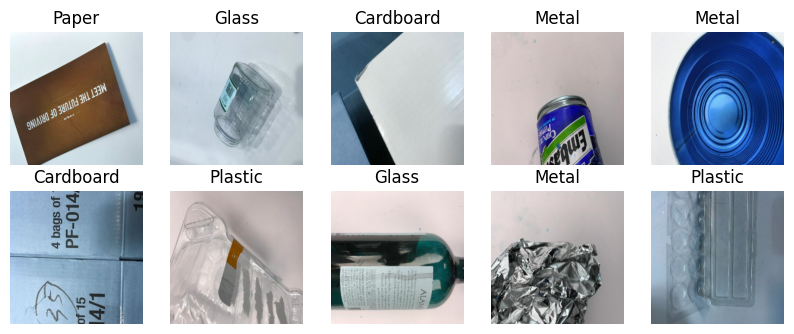

In [8]:
visualize_img(x,labels)

3-) Data Preparation (Veriyi Hazırlamak)

Data preproccessing + Data augmentation

In [9]:
# Data Augmentation, Veri arttırma, Gürültü ekleme

# Train veri seti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip      = True,  #rastgele yatay çevir
                           vertical_flip        = True,  #rastgele dikey çevir
                           validation_split     = 0.1,   #test veri setinin oranı
                           rescale              = 1./255,#rescale yeniden ölçeklendir. Normalleştirme. 0-1 arasına.
                           zoom_range           = 0.1,   #görüntünün şekline eğim verme (saat yönünün tersine göre)
                           width_shift_range    = 0.1,   #yatay kaydırma
                           height_shift_range   = 0.1)   #dikey kaydırma

# Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale           = 1./255,
                          validation_split  = 0.1)

In [10]:
train_generator = train.flow_from_directory(directory   = folder_path,   #resimlerin dizini
                                            target_size = (target_size), #boyutlarını ölçeklendirmek için kullanacağımız boyut bilgisi
                                            class_mode  = "categorical", #ilgilenilen ckategorik değişkenin sınıfını ifade eder. categorical=2'den fazla sınıf
                                            subset      = "training")    #ImageDateGenerator()'da validation_split kullanılmış ise
                                                                         #Verinin alt kümesinden "training" veya "validation" diye belirtilmeli.

test_generator  = test.flow_from_directory(directory    = folder_path,
                                           target_size  = (target_size),
                                           batch_size   = 251,           #veri gruplarının boyutu
                                           class_mode   = "categorical",
                                           subset       = "validation")

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


4-) Modelling (Modelleme)

4.1-) Sıfırdan CNN Modeli Kurma
- Sequential (Sıralı katmanlardan oluşan sinir ağı kurma yöntemi)
- Convolution Layer, Conv2D (Evrişim)
- Pooling     Layer (Havuzlama)
- Activation  Layer (Aktivasyon Fonksiyonu)
- Flattening  Layer (Tam Bağlantı) (Düzleştirme) (Matrix'i string yapma)
- Dense       Layer 
- Dropout     Layer (Sönümleme)

![](Convolutional_Neural_Network.png)

![](CNN_architecture.png)

In [11]:
#Modeli sıralı katmanlardan oluşacak diye başlatma ve layerları ekleme
model = Sequential()
#Convolution Layer                              #Giriş katmanından öznitelik çıkartma katmanı
model.add(Conv2D(filters=32,                    #Görüntü üzerinde gezdirilecek olan filtre sayısı.
                 kernel_size=(3,3),             #Filtrelerin boyutları.
                 padding="same",                #Çıkış matrisi boyutu = giriş matrisi boyutu olacak şekilde girdininin kenarlarına eşit olacak şekilde 0 pixel değerleri yerleştirir.
                 input_shape=(input_shape),     #Giriş görüntülerinin boyut bilgileri
                 activation="relu"))            #Activasyon fonksiyonu #activasyon katmanı bilgisi burada ifade edildi.
#Pooling Layer                            #Görüntünün özelliklerini kaybetmeden boyutunu azaltmak.   
model.add(MaxPooling2D(pool_size=2,       #MaxPooling yapılmış matrisin boyutu
                       strides=(2,2)))    #

#Convolution Layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding="same",
                 activation="relu"))
#Pooling Layer
model.add(MaxPooling2D(pool_size=2,
                       strides=(2,2)))
#Convolution Layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 padding="same",
                 activation="relu"))
#Pooling Layer
model.add(MaxPooling2D(pool_size=2,
                       strides=(2,2)))
#Flatten layer          #Giriş verilerindeki matrix'leri tek boyutlu dizi yapar.
model.add(Flatten())
#Dense Layer(hidden layer ekliyoruz)#Bir katmandaki nöronlardan aldığı bilgilerin, bir sonraki katmana girdi olarak bağlanmasını sağlar.
model.add(Dense(units=64,           #units: nöron sayısı
                activation="relu"))
#Dropout Layer               #overfittingi engellemek için belirli bir oranda rastgele nöron söndürme işlemi yapar.
model.add(Dropout(rate=0.2)) #%20 oranında sönümleme

#Dense Layer   
model.add(Dense(units=32,          
                activation="relu"))
#Dropout Layer              
model.add(Dropout(rate=0.2)) 
#Output Layer
model.add(Dense(units=6,
                activation="softmax"))#Çoklu sınıflandırma aktivasyon fonksiyonu.

4.2-) Model Summary

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

![](CNN_model_architecture.png)

4.3-) Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

In [13]:
model.compile(loss      = "categorical_crossentropy", #2'den fazla sınıfta kullanılır.
              optimizer = "adam",                     #Deneme yanılma yönüyle diğerleri de test edilebilir, genellikle çoklu sınıflandırma için adam daha iyi optimize eder.
              metrics   = [tf.keras.metrics.Precision(),#precission ve recall
                           tf.keras.metrics.Recall(),   # olası dengesizlik durumları
                           "acc"])                      #accuracy

In [16]:
#overfitting engellemek için;
#Bu nesnenin amacı model bilgilerini bir listeye kaydetmek.
             #ezberlemeye başlarsa dur.
callbacks = [EarlyStopping(monitor  = "val_loss", #modelin gelişimini hangi metrik açısından takip edeceğiz?
                           patience = 50,         #50 defada bir kontrol et, ilerleme olmazsa dur. Bu öğrenme değil ezberlenmeye başlanmıştır.
                           verbose  = 1,          #Bilgilendirme gösterir
                           mode     = "min"),     #model gelişiminin takip edileceği parametre, izlenen miktarın azalması durduğunda eğitim durur.
             #yakalanacak olan en iyi modelin kaydedilmesi.
             ModelCheckpoint(filepath           = "mymodel.keras", #isim
                             monitor            = "val_loss", #neye odaklandık?
                             mode               = "min",     
                             save_best_only     = True,       #en iyi modeli kaydet
                             save_weights_only  = False)]     #tüm modeli mi kaydetsin sadece ağırlıkları mı?

4.4-)Modelin Eğitilmesi

In [34]:
history = model.fit(train_generator,                       #train bilgileri
                    epochs              = 100,             #iterasyon sayısı
                    validation_data     = test_generator,  #test bilgileri
                    callbacks           = callbacks,       #overfitting'i engellemek için
                    #workers            = 0,               #paralel olarak gruplar oluşturan iş parçacığı sayısı(donanımsal parametre)
                    steps_per_epoch     = 2276//32,        #1 epoch tamamlandığındai sonraki epochun başladığını bildirmeden önceki toplam adım sayısı.
                    validation_steps    = 251//32)         #1 epoch tamamlandığındai sonraki epochun başladığını bildirmeden önceki toplam adım sayısı.

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 587ms/step - acc: 0.2097 - loss: 1.7999 - precision: 0.0365 - recall: 0.0017 - val_acc: 0.2351 - val_loss: 1.7666 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.1875 - loss: 1.7675 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.2351 - val_loss: 1.7670 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - acc: 0.2089 - loss: 1.7488 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.2351 - val_loss: 1.6892 - val_precision: 0.7500 - val_recall: 0.0120
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.2188 - loss: 1.7921 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.2351 - val_loss: 1.6756 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 541ms/step - acc: 0.2509 - loss: 1.6723 - precision: 0.6144 - recall: 0.0134 - val_acc: 0.3865 - val_loss: 1.5638

4.5-) Accuracy ve Loss Grafikleri

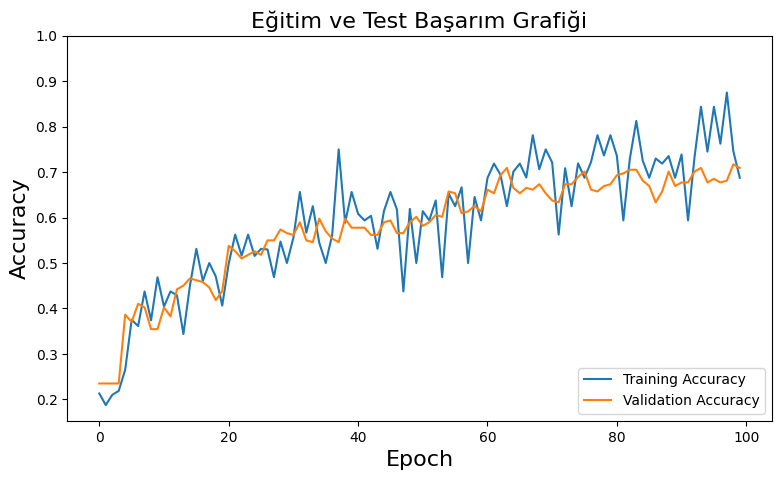

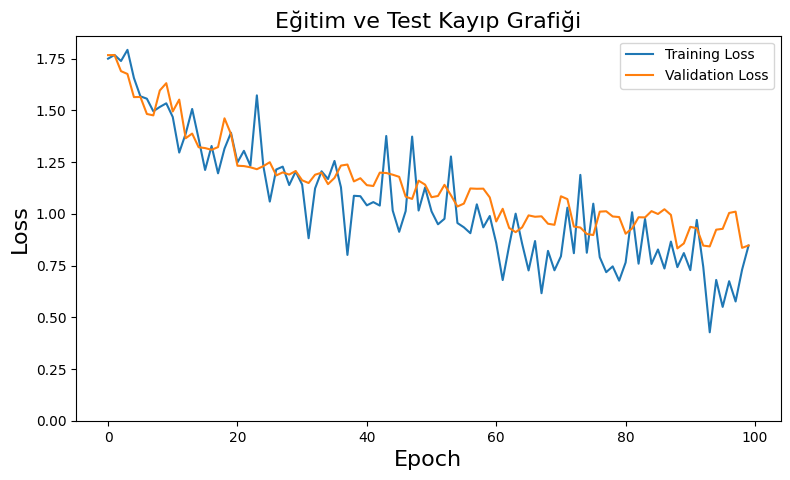

In [35]:
###############################
# Accuracy ve Loss Grafikleri #
###############################

#------------------Grafik 1 Accuracy------------------
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Eğitim ve Test Başarım Grafiği", fontsize=16)
#------------------Grafik 2 Loss------------------
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Eğitim ve Test Kayıp Grafiği", fontsize=16)
plt.show()

5-) Evalation (Değerlendirme)

In [36]:
loss, precision, recall, acc = model.evaluate(test_generator,batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.7092 - loss: 0.8470 - precision: 0.8278 - recall: 0.5936


In [37]:
print("\nTest Accuracy: %.1f%%" % (100.0*acc))
print("\nTest Loss: %.1f%%" % (100.0*loss))
print("\nTest Precision: %.1f%%" % (100.0*precision))
print("\nTest Recall: %.1f%%" % (100.0*recall))

# precission: model ile örneğin 1 olarak tahmin ettiğimiz değerlerin gerçekten de 1 olup olmadığının başarısı
# recall    : gerçek değerlerin kaç tanesi doğru tahmin edildi. 


# precission: tahminlerin kaçı gerçek değerlerle aynı?
# recall    : gerçeklerin kaçı doğru tahmin edildi?


Test Accuracy: 70.9%

Test Loss: 84.7%

Test Precision: 82.8%

Test Recall: 59.4%


In [39]:
# Classification Report
x_test, y_test = next(test_generator)
y_pred = model.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


In [40]:
y_pred

array([[3.8458797e-01, 2.1620532e-02, 3.0306906e-01, 2.6188397e-01,
        2.0668404e-02, 8.1700822e-03],
       [3.5850968e-02, 7.2119748e-03, 7.7827744e-02, 8.2401842e-01,
        2.6978342e-02, 2.8112572e-02],
       [1.5101017e-03, 1.4344886e-01, 6.1845863e-01, 3.8493164e-03,
        2.0657769e-01, 2.6155435e-02],
       ...,
       [7.3201191e-03, 4.0689948e-01, 2.2092558e-01, 4.6337966e-02,
        1.4775032e-01, 1.7076655e-01],
       [3.2095317e-02, 2.8353584e-01, 2.8225127e-01, 8.1424102e-02,
        1.6264677e-01, 1.5804665e-01],
       [9.9570775e-01, 1.8232832e-04, 3.5072182e-04, 1.9584977e-04,
        3.4580997e-03, 1.0520459e-04]], dtype=float32)

In [41]:
#modelin hangi sınıfı tahmin ettiği bilgisi
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

In [42]:
y_pred

array([0, 3, 2, 0, 4, 3, 3, 4, 2, 4, 0, 2, 3, 1, 5, 1, 3, 2, 4, 3, 3, 1,
       2, 3, 4, 2, 5, 3, 1, 4, 1, 1, 3, 3, 0, 2, 4, 3, 2, 4, 0, 3, 1, 2,
       3, 3, 3, 1, 0, 2, 1, 3, 2, 0, 0, 1, 4, 0, 2, 4, 0, 5, 0, 4, 3, 3,
       3, 0, 4, 3, 0, 1, 1, 0, 3, 2, 4, 2, 0, 5, 2, 1, 1, 1, 2, 2, 4, 5,
       3, 0, 0, 1, 1, 3, 4, 4, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 5, 4, 1, 2,
       2, 3, 3, 4, 3, 2, 2, 5, 2, 0, 2, 2, 0, 3, 4, 4, 3, 4, 0, 3, 1, 5,
       3, 1, 1, 3, 5, 1, 1, 5, 3, 0, 3, 3, 0, 3, 1, 1, 3, 0, 5, 0, 3, 4,
       4, 2, 2, 0, 4, 0, 0, 2, 3, 4, 0, 2, 3, 2, 0, 3, 1, 4, 2, 5, 5, 0,
       5, 0, 4, 3, 3, 5, 3, 0, 1, 2, 0, 3, 3, 2, 2, 1, 3, 0, 1, 0, 0, 2,
       3, 0, 3, 1, 3, 0, 0, 2, 1, 2, 0, 2, 4, 1, 2, 2, 2, 4, 5, 5, 0, 3,
       1, 3, 1, 1, 0, 0, 2, 4, 4, 2, 3, 2, 3, 2, 2, 2, 4, 1, 3, 0, 1, 1,
       1, 3, 1, 3, 5, 5, 1, 1, 0], dtype=int64)

In [43]:
y_test

array([2, 3, 2, 0, 4, 3, 3, 4, 2, 1, 1, 2, 3, 1, 4, 0, 3, 2, 1, 3, 3, 2,
       1, 3, 4, 0, 5, 3, 1, 2, 1, 4, 3, 3, 0, 2, 4, 3, 4, 4, 4, 3, 1, 2,
       3, 2, 3, 1, 0, 2, 1, 4, 2, 4, 0, 4, 4, 0, 2, 4, 4, 5, 0, 4, 2, 3,
       3, 1, 4, 3, 0, 1, 1, 0, 3, 4, 4, 2, 0, 5, 2, 2, 4, 1, 1, 2, 4, 4,
       2, 0, 0, 1, 1, 2, 1, 4, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 5, 4, 1, 2,
       2, 3, 3, 4, 3, 0, 2, 4, 2, 0, 2, 2, 4, 3, 4, 5, 3, 4, 0, 3, 1, 5,
       3, 1, 4, 3, 4, 1, 1, 0, 4, 5, 3, 3, 3, 3, 1, 1, 3, 0, 1, 0, 3, 4,
       1, 4, 1, 0, 4, 1, 4, 2, 2, 3, 0, 4, 3, 0, 0, 3, 4, 4, 2, 5, 5, 5,
       2, 0, 3, 3, 1, 0, 3, 0, 1, 1, 0, 3, 3, 2, 2, 1, 3, 0, 1, 0, 0, 4,
       3, 0, 3, 1, 4, 1, 0, 2, 1, 1, 3, 2, 4, 1, 2, 1, 0, 2, 0, 5, 4, 3,
       1, 3, 1, 2, 0, 0, 1, 1, 4, 0, 5, 2, 3, 4, 2, 2, 4, 1, 3, 0, 1, 1,
       1, 3, 1, 3, 5, 4, 4, 1, 0], dtype=int64)

In [44]:
target_names = list(waste_labels.keys())

In [46]:
print(classification_report(y_test,y_pred,target_names=target_names))
#f1-score; precision ve recall'ın harmonik ortalaması

              precision    recall  f1-score   support

   cardboard       0.67      0.78      0.72        40
       glass       0.76      0.64      0.70        50
       metal       0.62      0.71      0.66        41
       paper       0.85      0.93      0.89        59
     plastic       0.69      0.46      0.55        48
       trash       0.47      0.69      0.56        13

    accuracy                           0.71       251
   macro avg       0.68      0.70      0.68       251
weighted avg       0.71      0.71      0.70       251



In [58]:
#Confusion Matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm,classes,
                          normalize =False,
                          title     ="confusion matrix",
                          cmap      = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting "normalize=True"
    """
    if normalize:
        cm=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    plt.imshow(cm,interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color = "white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Label",fontweight="bold")
    plt.xlabel("Predicted Label",fontweight="bold")

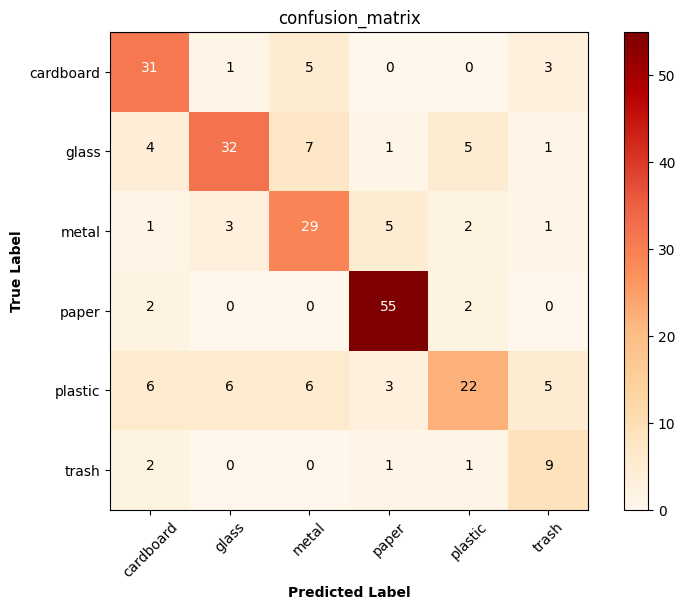

In [59]:
plot_confusion_matrix(cm,waste_labels.keys(),
                      title="confusion_matrix",
                      cmap=plt.cm.OrRd)

paper olan resimlerin 55 tanesine paper 2 tanesine card board 2 tanesine plastic denmiş.

6-) Using it to Predict (Tahmin İçin Kullanılması)

In [65]:
waste_labels = {0:'cardboard', 
                1:'glass', 
                2:'metal', 
                3:'paper', 
                4:'plastic', 
                5:'trash'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


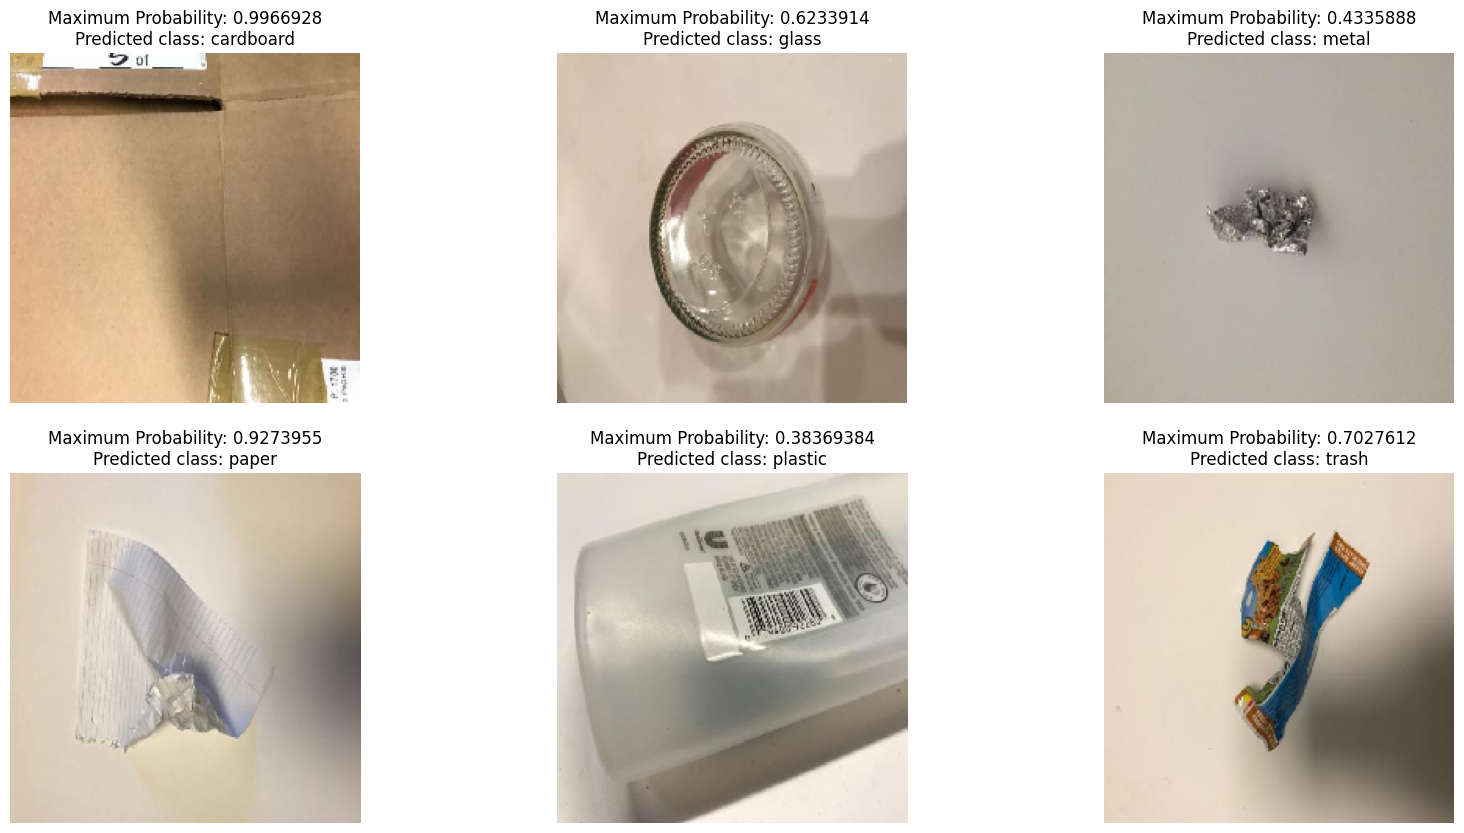

In [74]:
def model_testing(path):
    """
    Görselin bulunduğu dizindeki görüntüyü okuyup 
    model aracılığı ile hangi sınıfa ait olduğuna 
    dair tahmin işlemi gerçekleştirir.
    Parametreler:
    path: görsellerin bulunduğu dizin.
    Return:
    img: Görüntü
    p: Tahmin Olasılıkları
    predicted_class: Tahmin edilen sınıfı.
    """
    img = image.load_img(path,target_size=(target_size))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    p=model.predict(img.reshape(1,224,224,3))
    predicted_class=np.argmax(p[0])

    return img, p, predicted_class

img1,p1,predicted_class1 = model_testing("Garbage_classification/cardboard/cardboard155.jpg")
img2,p2,predicted_class2 = model_testing("Garbage_classification/glass/glass160.jpg")
img3,p3,predicted_class3 = model_testing("Garbage_classification/metal/metal165.jpg")
img4,p4,predicted_class4 = model_testing("Garbage_classification/paper/paper170.jpg")
img5,p5,predicted_class5 = model_testing("Garbage_classification/plastic/plastic175.jpg")
img6,p6,predicted_class6 = model_testing("Garbage_classification/trash/trash19.jpg")

plt.figure(figsize=(20,10))

plt.subplot(231)
plt.axis("off")
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis=-1)) + 
          "\nPredicted class: " + str(waste_labels[predicted_class1]))

plt.subplot(232)
plt.axis("off")
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis=-1)) + 
          "\nPredicted class: " + str(waste_labels[predicted_class2]))

plt.subplot(233)
plt.axis("off")
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis=-1)) + 
          "\nPredicted class: " + str(waste_labels[predicted_class3]))

plt.subplot(234)
plt.axis("off")
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis=-1)) + 
          "\nPredicted class: " + str(waste_labels[predicted_class4]))

plt.subplot(235)
plt.axis("off")
plt.imshow(img5.squeeze())
plt.title("Maximum Probability: " + str(np.max(p5[0], axis=-1)) + 
          "\nPredicted class: " + str(waste_labels[predicted_class5]))

plt.subplot(236)
plt.axis("off")
plt.imshow(img6.squeeze())
plt.title("Maximum Probability: " + str(np.max(p6[0], axis=-1)) + 
          "\nPredicted class: " + str(waste_labels[predicted_class6]))

plt.show()